In [ ]:
#I don't know other way than this to display the graph:(

In [7]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from tools.searchFacebook import SearchFacebook
from langgraph.prebuilt import ToolNode
from langchain.tools import Tool
from langchain.tools import StructuredTool
import os
import json
from langchain_core.messages import ToolMessage
from IPython.display import Image, display
from tools.base_tool import BaseTool
from langgraph.checkpoint.memory import MemorySaver
import time
from pydantic import BaseModel, Field
from typing import Any
from tools.coordinatesInput import CoordinatesInput
from tools.getCooridinates import GetCoordinates

load_dotenv()

print("running...")

memory = MemorySaver()


class State(TypedDict):
    """State of the agent"""

    messages: Annotated[list, add_messages]


class WebScraperInput(BaseModel):
    lat: float = Field(description="The latitude of the location to search for")
    lon: float = Field(description="The longitude of the location to search for")
    minBudget: float = Field(description="The minimum budget for the rental")
    maxBudget: float = Field(description="The maximum budget for the rental")
    minBedrooms: int = Field(
        description="The minimum number of bedrooms for the rental"
    )
    maxBedrooms: int = Field(
        description="The maximum number of bedrooms for the rental"
    )
    


print("state initialized...")

url = "https://www.facebook.com/marketplace/montreal/propertyrentals"

# instantiate the tools
scraper = SearchFacebook(url)
coordinates_finder = GetCoordinates()

config = {"configurable": {"thread_id": "1"}}
# search facebook Marketplace according to the provided parameters
search_tool = StructuredTool.from_function(
    func=scraper.execute,
    name=scraper.name,
    description=scraper.description,
    args_schema=WebScraperInput,
)

# find coordinates of locations based on OpenStreetMap tags (schools, parks, restaurants, etc.)
coordinates_tool = StructuredTool.from_function(
    func=coordinates_finder.execute,
    name=coordinates_finder.name,
    description=coordinates_finder.description,
    args_schema=CoordinatesInput,
)

tools = [search_tool, coordinates_tool]


print("tools initialized...")

graphBuilder = StateGraph(State)

print("graphBuilder initialized...")

t0 = time.time()
# init the llm
moveout = init_chat_model("gpt-4o-mini", model_provider="openai")
print(f"⚡ init_chat_model a pris {time.time() - t0:.2f}s")

moveout = moveout.bind_tools(tools)

print("moveout llm initialized and binded to tools...")


def chatbot(state: State):
    # get the last message
    return {"messages": [moveout.invoke(state["messages"])]}


# building the tool executing node
class BasicToolNode:
    """A node that run the tool requested by user"""

    def __init__(self, tools: list) -> None:
        # create a dictionary of tools by name
        self.tools_by_name = {search_tool.name: search_tool for search_tool in tools}

    def __call__(self, inputs: dict):
        # walrus operator  assign message or empty list if it's empty the if statement is false
        if messages := inputs.get("messages", []):
            # get latest message
            message = messages[-1]
        else:
            raise ValueError("No messages found in input")
        outputs = []
        for tool_call in message.tool_calls:
            print(
                f"[BasicToolNode] appel de '{tool_call['name']}' avec args={tool_call['args']}"
            )
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            print("[BasicToolNode] résultat retourné :", tool_result)
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

            return {"messages": outputs}


def route_tools(
    state: State,
):
    """use conditional_edge to route to the tool node if the last message contains
    a tool call otherwise route to the end"""

    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool"
    return END


graphBuilder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graphBuilder.add_node("tool_node", tool_node)

graphBuilder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tool": "tool_node", END: END},
)


graphBuilder.add_edge("tool_node", "chatbot")
graphBuilder.add_edge(START, "chatbot")
# graphBuilder.add_edge("chatbot", END)
graph = graphBuilder.compile(checkpointer=memory)

/Users/jerrybenoit/Desktop/moveout3.0/ai/lib/python3.12/site-packages/seleniumwire/thirdparty/mitmproxy/contrib/kaitaistruct/tls_client_hello.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


running...
state initialized...
initialisation du scraper facebook...
Chrome options chargées
les options de sessions sont chargées
graphql request found
tools initialized...
graphBuilder initialized...
⚡ init_chat_model a pris 0.71s
moveout llm initialized and binded to tools...


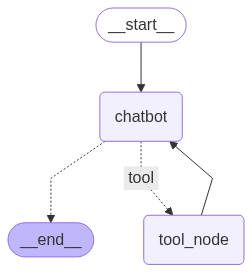

In [8]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass